<a href="https://colab.research.google.com/github/Zahra2351373/Image-Processing-Tutorials/blob/Master/Tutorial_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
from keras import callbacks
from keras import backend as K
from tensorflow import keras
from __future__ import division
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.optimizers import *
from keras.layers import *        
import tensorflow as tf

%matplotlib inline

In [ ]:
# Download url of lung images.
url = "https://github.com/hasibzunair/cu-comp478-lab/releases/download/v0.0.1/LUNGS_images.npy"
filename = os.path.join(os.getcwd(), "LUNGS_images.npy")
keras.utils.get_file(filename, url)

# Download url of lung segmentation masks
url = "https://github.com/hasibzunair/cu-comp478-lab/releases/download/v0.0.1/LUNGS_mask.npy"
filename = os.path.join(os.getcwd(), "LUNGS_mask.npy")
keras.utils.get_file(filename, url)

In [ ]:
data = np.load("LUNGS_images.npy") 
labels = np.load("LUNGS_mask.npy")
print(data.shape, labels.shape)

In [ ]:
# define 10 random numbers
rand = [random.randint(0, 1000) for _ in range(10)]

for img, mask in zip(data[rand], labels[rand]):
    print(img.shape, mask.shape)
    img = np.squeeze(img, axis=-1) # change to H, W
    mask = np.squeeze(mask, axis=-1) # change to H, W

    plt.figure(figsize=(14,12))
    plt.subplot(1,2,1)
    plt.title('Input')
    plt.imshow(img, cmap='gray')
    plt.grid(False)

    plt.subplot(1,2,2)
    plt.grid(False)
    plt.title('Ground Truth Mask')
    plt.imshow(mask, cmap='gray')
    plt.show()

In [5]:
# From https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def unet(input_size = (256,256,1)):
    "Baseline Unet"
    
    inputs = Input(input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # Binary segmentation
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) 

    model = Model(inputs=[inputs], outputs=[conv10])

    # Compile model with optim and loss
    optim = 'adam' 
    
    # If bin seg, use bce loss, or categorical_crossentropy for multi class
    loss_func = 'binary_crossentropy'  
    
    model.compile(optimizer = optim, loss = loss_func, metrics = [jacard, dice_coef])

    return model


# Metrics
smooth = 1
def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [6]:
# Plot and save accuravy loss graphs individually
def plot_loss_accu(history):
    loss = history.history['loss'][1:]
    val_loss = history.history['val_loss'][1:]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'y')
    plt.title('Training and validation loss')
    plt.ylabel('Loss %')
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.grid(True)
    plt.show()
    
    loss = history.history['jacard'][1:]
    val_loss = history.history['val_jacard'][1:]
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation jaccard index')
    plt.ylabel('Accuracy %')
    plt.xlabel('Epoch')
    plt.legend(['training', 'validation'], loc='lower right')
    plt.grid(True)
    plt.show()

In [7]:
# Build model
model = unet(input_size = (data.shape[1], data.shape[2], data.shape[-1]))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, shuffle=True, test_size=0.20, random_state=42)
print("Data shapes-------> ", x_train.shape, x_test.shape, y_train.shape, y_test.shape)

Data shapes------->  (816, 256, 256, 1) (205, 256, 256, 1) (816, 256, 256, 1) (205, 256, 256, 1)


Epoch 1/10
102/102 [==============================] - 80s 434ms/step - loss: 0.5958 - jacard: 0.2768 - dice_coef: 0.4138 - val_loss: 0.2157 - val_jacard: 0.6024 - val_dice_coef: 0.7513
Epoch 2/10
102/102 [==============================] - 41s 404ms/step - loss: 0.1169 - jacard: 0.6684 - dice_coef: 0.7833 - val_loss: 0.0223 - val_jacard: 0.9440 - val_dice_coef: 0.9712
Epoch 3/10
102/102 [==============================] - 41s 403ms/step - loss: 0.0199 - jacard: 0.9366 - dice_coef: 0.9672 - val_loss: 0.0168 - val_jacard: 0.9486 - val_dice_coef: 0.9736
Epoch 4/10
102/102 [==============================] - 41s 403ms/step - loss: 0.0199 - jacard: 0.9382 - dice_coef: 0.9680 - val_loss: 0.0142 - val_jacard: 0.9515 - val_dice_coef: 0.9751
Epoch 5/10
102/102 [==============================] - 41s 403ms/step - loss: 0.0130 - jacard: 0.9539 - dice_coef: 0.9764 - val_loss: 0.0113 - val_jacard: 0.9610 - val_dice_coef: 0.9801
Epoch 6/10
102/102 [==============================] - 41s 403ms/step - loss

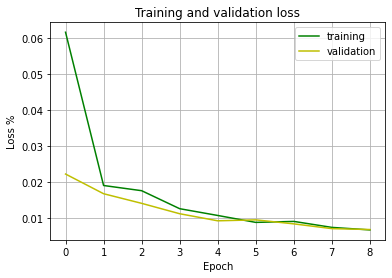

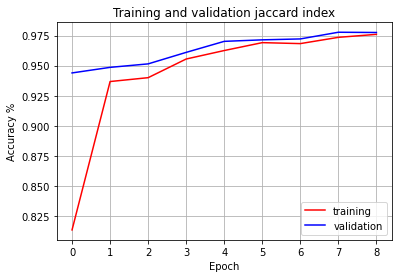

In [9]:
# Train
batch_size = 8
epochs = 10
history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_test, y_test),
                shuffle=True)

# Plot model training history
plot_loss_accu(history)

In [10]:
# Evaluate trained model using Jaccard and Dice metric
yp = None
yp = model.predict(x=x_test, batch_size=batch_size, verbose=0)
#Round off boolean masks
yp = np.round(yp,0)

In [ ]:
for i in range(5):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    if len(x_test[i].shape) >= 2:
        plt.grid(False)
        plt.imshow(x_test[i].squeeze(), cmap='gray') # 1-channel image
    else:
        plt.grid(False)
        plt.imshow(x_test[i]) # 3-channel
        
    plt.title('Input')
    plt.subplot(1,3,2)
    plt.grid(False)
    plt.imshow(y_test[i].reshape(y_test[i].shape[0],y_test[i].shape[1]), cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1,3,3)
    plt.grid(False)
    plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]),cmap='gray')
    plt.title('Prediction')
    
    # Calc jaccard index of predictions
    intersection = yp[i].ravel() * y_test[i].ravel()
    union = yp[i].ravel() + y_test[i].ravel() - intersection
    jacard = (np.sum(intersection)/np.sum(union))  
    plt.suptitle('Jacard Index: '+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +' = '+str(jacard))
    plt.show()
    plt.close()
